In [169]:
import pandas as pd
import numpy as np
from graphdatascience import GraphDataScience # Load neo4j graph data science library
import os

if os.getcwd().split('\\')[-1] == 'notebooks':
    os.chdir('..')

In [74]:
# Connect to a Neo4j instance (assumes local right now)
NEO4J_URI = os.environ.get("NEO4J_URI", "bolt://localhost:7687")
NEO4J_AUTH = None
NEO4J_DB = os.environ.get("NEO4J_DB", "neo4j")
if os.environ.get("NEO4J_USER") and os.environ.get("NEO4J_PASSWORD"):
    NEO4J_AUTH = (
        os.environ.get("NEO4J_USER"),
        os.environ.get("NEO4J_PASSWORD"),
    )
else:
    NEO4J_AUTH = ("neo4j", "Bookings")
gds = GraphDataScience(NEO4J_URI, auth=NEO4J_AUTH, database=NEO4J_DB)

In [76]:
# Embedding dimension for properties
# Get the projection
if 'properties-embedding' in gds.graph.list().graphName.values:
    gds.graph.drop("properties-embedding")

# We can embed all property information since that is not what we're trying to predict
gds.graph.project("properties-embedding",
                  node_spec=['Property', 'City', 'Country', 'Type'],
                  relationship_spec=['LOCATED_IN', 'HAS_TYPE'])


# Run the FastRP algorithm to generate embeddings
gds.fastRP.write(
    gds.graph.get("properties-embedding"),
    embeddingDimension = 64,
    writeProperty = "property_embedding"
)

nodeCount                                                             1019
nodePropertiesWritten                                                 1019
preProcessingMillis                                                      0
computeMillis                                                            6
writeMillis                                                              8
configuration            {'writeProperty': 'property_embedding', 'jobId...
Name: 0, dtype: object

In [77]:
# Look at the embedding outputs
gds.run_cypher("MATCH (p:Property) RETURN p.id, p.property_embedding LIMIT 5")

,p.id,p.property_embedding
0,0,"[0.0, 0.0, 0.0, 0.22360679507255554, -0.223606..."
1,1,"[0.0, 0.0, 0.0, 0.22360679507255554, -0.223606..."
2,2,"[0.0, 0.2357022613286972, 0.0, 0.0, 0.23570226..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2236067950725..."
4,4,"[0.0, 0.0, 0.0, 0.22360679507255554, -0.223606..."


In [140]:
# Week Degree Centrality
if 'week-degree' in gds.graph.list().graphName.values:
    gds.graph.drop("week-degree")

gds.graph.project("week-degree",
                  node_spec=["Property", "Week"],
                  relationship_spec={
                      "TRAIN_BOOKING":{"orientation":"REVERSE"}, # Reverse because the gds implementation only looks at outgoing relationships
                  })

gds.degree.write(
    gds.graph.get("week-degree"),
    relationshipTypes=["TRAIN_BOOKING"],
    writeProperty="week_degree"
)

nodePropertiesWritten                                                  1052
writeMillis                                                              15
centralityDistribution    {'min': 0.0, 'max': 508.00195312499994, 'p90':...
postProcessingMillis                                                     16
preProcessingMillis                                                       0
computeMillis                                                             0
configuration             {'writeProperty': 'week_degree', 'orientation'...
Name: 0, dtype: object

<Axes: xlabel='w.week_num'>

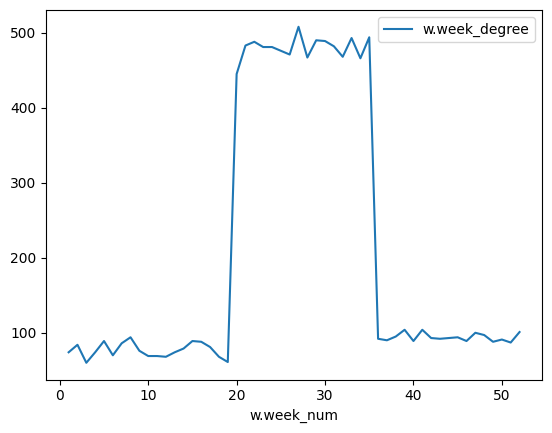

In [141]:
bookings_by_week = gds.run_cypher("""
MATCH(w:Week)
RETURN w.week_num, w.week_degree
""").sort_values("w.week_num")

bookings_by_week.plot(x="w.week_num", y="w.week_degree", kind="line")

In [170]:
# Need to do link prediction within individual queries -- DO THIS ON THE TRAIN DATA ONLY OR THERE WILL BE DATA LEAKAGE
city_week_pref_attachment = gds.run_cypher("""
MATCH (w:Week)<-[:TRAIN_BOOKING]-(p:Property)-[:LOCATED_IN]-> (c:City)
RETURN DISTINCT c.name AS city, w.week_num AS week_num, gds.alpha.linkprediction.preferentialAttachment(c, w) as city_week_pref_attachment
ORDER BY city, week_num
""")

cities = city_week_pref_attachment[['city']].drop_duplicates()
week_nums = pd.DataFrame({"week_num": list(range(1, 53))})

# Fill in missing weeks with the minimum attachment value for that city
city_week_pref_attachment = (
    pd.merge(cities, week_nums, how="cross")
    .merge(city_week_pref_attachment, how="left", on=["city", "week_num"])
    .sort_values(["city", 'week_num'], ascending=True)
    .merge(city_week_pref_attachment.groupby("city", as_index=False).agg(min_week_pref_attach=("city_week_pref_attachment", "min")), on="city", how="left")
    .assign(city_week_pref_attachment=lambda x: np.where(x.city_week_pref_attachment.isna(), x.min_week_pref_attach, x.city_week_pref_attachment))
    .drop(columns=["min_week_pref_attach"])
)

city_week_pref_attachment.to_csv("Inputs/city_week_pref_attachment.csv", index=False)

city_week_pref_attachment

,city,week_num,city_week_pref_attachment
0,Antwerp,1,184426.0
1,Antwerp,2,184426.0
2,Antwerp,3,184426.0
3,Antwerp,4,184426.0
4,Antwerp,5,184426.0
...,...,...,...
567,Rome,48,32904.0
568,Rome,49,31104.0
569,Rome,50,31392.0
570,Rome,51,29736.0
